In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the MUTAG dataset
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', transform=NormalizeFeatures())

# Define the GCN model for graph classification
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # global mean pooling
        x = F.dropout(x, p=0.5, training=self.training)
        return x, self.lin(x)

# Initialize the model, optimizer, and dataloader
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Create data loaders
train_loader = DataLoader(dataset[:150], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset[150:], batch_size=32, shuffle=False)

# Define the training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        _, out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# Define the test function
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        _, out = model(data)
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print('Training complete')




Processing...
Done!


Epoch: 010, Loss: 0.6163, Train Acc: 0.6600, Test Acc: 0.6842
Epoch: 020, Loss: 0.5574, Train Acc: 0.7800, Test Acc: 0.7105
Epoch: 030, Loss: 0.5350, Train Acc: 0.7467, Test Acc: 0.6579
Epoch: 040, Loss: 0.5363, Train Acc: 0.7600, Test Acc: 0.7105
Epoch: 050, Loss: 0.4967, Train Acc: 0.7667, Test Acc: 0.7105
Epoch: 060, Loss: 0.5108, Train Acc: 0.7867, Test Acc: 0.7105
Epoch: 070, Loss: 0.5257, Train Acc: 0.7400, Test Acc: 0.6579
Epoch: 080, Loss: 0.5098, Train Acc: 0.7800, Test Acc: 0.7105
Epoch: 090, Loss: 0.5449, Train Acc: 0.7800, Test Acc: 0.7105
Epoch: 100, Loss: 0.5081, Train Acc: 0.7800, Test Acc: 0.7105
Epoch: 110, Loss: 0.4936, Train Acc: 0.7467, Test Acc: 0.6579
Epoch: 120, Loss: 0.5156, Train Acc: 0.7667, Test Acc: 0.7105
Epoch: 130, Loss: 0.4799, Train Acc: 0.7533, Test Acc: 0.6579
Epoch: 140, Loss: 0.4890, Train Acc: 0.7533, Test Acc: 0.6579
Epoch: 150, Loss: 0.5090, Train Acc: 0.7867, Test Acc: 0.7105
Epoch: 160, Loss: 0.4855, Train Acc: 0.7600, Test Acc: 0.6579
Epoch: 1

In [ ]:
# prompt: classification report of model

from sklearn.metrics import classification_report

# Get predictions for the test set
model.eval()
predictions = []
true_labels = []
for data in test_loader:
    _, out = model(data)
    predictions.extend(out.argmax(dim=1).tolist())
    true_labels.extend(data.y.tolist())

# Generate the classification report
report = classification_report(true_labels, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.54      0.58      0.56        12
           1       0.80      0.77      0.78        26

    accuracy                           0.71        38
   macro avg       0.67      0.68      0.67        38
weighted avg       0.72      0.71      0.71        38



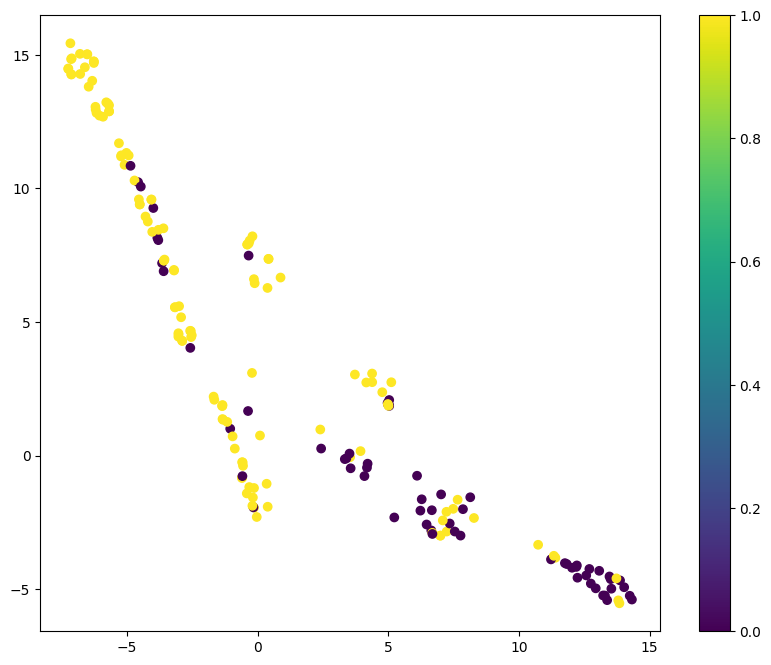

In [3]:
# Extract activations for the entire dataset
def extract_activations(loader):
    model.eval()
    activations = []
    labels = []
    for data in loader:
        x, _ = model(data)
        activations.append(x)
        labels.append(data.y)
    activations = torch.cat(activations, dim=0)
    labels = torch.cat(labels, dim=0)
    return activations, labels

activations, labels = extract_activations(DataLoader(dataset, batch_size=32))

# Apply t-SNE to the activations
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
activations_tsne = tsne.fit_transform(activations.detach().cpu().numpy())

# Plot t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(activations_tsne[:, 0], activations_tsne[:, 1], c=labels.cpu(), cmap='viridis')
plt.colorbar(scatter)


plt.show()

In [ ]:
# prompt: relative cluster size comparison

# Calculate the number of nodes in each cluster
cluster_sizes = [len(labels[labels == i]) for i in range(dataset.num_classes)]

# Calculate the relative cluster size
relative_cluster_sizes = [size / len(labels) for size in cluster_sizes]

# Print the relative cluster sizes
print("Relative cluster sizes:", relative_cluster_sizes)


Relative cluster sizes: [0.3351063829787234, 0.6648936170212766]


In [ ]:
# prompt: calculate silhouette_score, davies_bouldin_score and calinski_harabasz_score

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate the silhouette_score
silhouette_score = silhouette_score(activations_tsne, labels)

# Calculate the davies_bouldin_score
davies_bouldin_score = davies_bouldin_score(activations_tsne, labels)

# Calculate the calinski_harabasz_score
calinski_harabasz_score = calinski_harabasz_score(activations_tsne, labels)

# Print the scores
print("Silhouette Score:", silhouette_score)
print("Davies-Bouldin Score:", davies_bouldin_score)
print("Calinski-Harabasz Score:", calinski_harabasz_score)


Silhouette Score: 0.22075292
Davies-Bouldin Score: 1.3469064552091556
Calinski-Harabasz Score: 65.2585324841233


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# Load the MUTAG dataset
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', transform=NormalizeFeatures())

# Data augmentation functions
def augment_data(data):
    # Node feature augmentation: Add Gaussian noise to node features
    noise = torch.randn_like(data.x) * 0.1
    data.x = data.x + noise

    # Edge perturbation: Randomly add or remove edges
    edge_index = data.edge_index.clone()
    num_edges = edge_index.size(1)

    # Randomly remove edges
    num_remove = int(0.1 * num_edges)
    remove_indices = random.sample(range(num_edges), num_remove)
    edge_index = edge_index[:, ~torch.tensor(remove_indices)]

    # Randomly add edges
    num_add = int(0.1 * num_edges)
    for _ in range(num_add):
        i, j = random.sample(range(data.num_nodes), 2)
        edge_index = torch.cat([edge_index, torch.tensor([[i], [j]], dtype=torch.long)], dim=1)

    data.edge_index = edge_index
    return data

# Apply data augmentation to the dataset
augmented_dataset = [augment_data(data.clone()) for data in dataset]

# Define the GCN model for graph classification
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # global mean pooling
        x = F.dropout(x, p=0.5, training=self.training)
        return x, self.lin(x)

# Initialize the model, optimizer, and dataloader
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Create data loaders
train_loader = DataLoader(augmented_dataset[:150], batch_size=32, shuffle=True)
test_loader = DataLoader(augmented_dataset[150:], batch_size=32, shuffle=False)

# Define the training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        _, out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# Define the test function
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        _, out = model(data)
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print('Training complete')


Epoch: 010, Loss: 0.6128, Train Acc: 0.6600, Test Acc: 0.6842
Epoch: 020, Loss: 0.5963, Train Acc: 0.7467, Test Acc: 0.7368
Epoch: 030, Loss: 0.5632, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 040, Loss: 0.5390, Train Acc: 0.7333, Test Acc: 0.7632
Epoch: 050, Loss: 0.5251, Train Acc: 0.7533, Test Acc: 0.7895
Epoch: 060, Loss: 0.5677, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 070, Loss: 0.5498, Train Acc: 0.7600, Test Acc: 0.7632
Epoch: 080, Loss: 0.5346, Train Acc: 0.7533, Test Acc: 0.7632
Epoch: 090, Loss: 0.5395, Train Acc: 0.7667, Test Acc: 0.7895
Epoch: 100, Loss: 0.5180, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 110, Loss: 0.5455, Train Acc: 0.7600, Test Acc: 0.7632
Epoch: 120, Loss: 0.5208, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 130, Loss: 0.5155, Train Acc: 0.7800, Test Acc: 0.7632
Epoch: 140, Loss: 0.4969, Train Acc: 0.7800, Test Acc: 0.7632
Epoch: 150, Loss: 0.5429, Train Acc: 0.8000, Test Acc: 0.7632
Epoch: 160, Loss: 0.4869, Train Acc: 0.8067, Test Acc: 0.7632
Epoch: 1

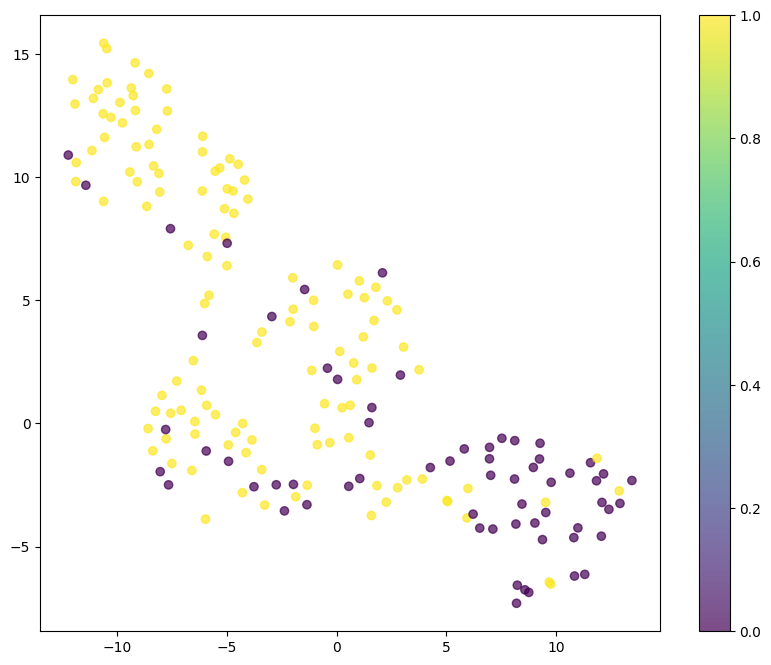

In [5]:
# prompt: extract model activation and use tSNE cluster

# Extract activations for the entire dataset
def extract_activations(loader):
    model.eval()
    activations_p = []
    labels = []
    for data in loader:
        x, _ = model(data)
        activations_p.append(x)
        labels.append(data.y)
    activations_p = torch.cat(activations_p, dim=0)
    labels = torch.cat(labels, dim=0)
    return activations_p, labels

activations_p, labels = extract_activations(DataLoader(augmented_dataset, batch_size=32))

# Apply t-SNE to the activations
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
activations_tsne = tsne.fit_transform(activations_p.detach().cpu().numpy())

# Plot t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(activations_tsne[:, 0], activations_tsne[:, 1],c=labels.cpu(), cmap='viridis', alpha=0.7)
plt.colorbar(scatter)


plt.show()


In [ ]:
activations

tensor([[0.1159, 0.1831, 0.0000,  ..., 0.1730, 0.1424, 0.0000],
        [0.0401, 0.0675, 0.0000,  ..., 0.0596, 0.0482, 0.1065],
        [0.0249, 0.0414, 0.0000,  ..., 0.0379, 0.0309, 0.0983],
        ...,
        [0.0024, 0.0076, 0.0000,  ..., 0.0024, 0.0015, 0.1006],
        [0.1281, 0.2017, 0.0000,  ..., 0.1911, 0.1574, 0.0000],
        [0.0341, 0.0591, 0.0000,  ..., 0.0499, 0.0399, 0.0530]],
       grad_fn=<CatBackward0>)

In [6]:
# prompt: Calculate the mean and standard deviation of the activations and activations_p

mean_activations = activations.mean(dim=0)
std_activations = activations.std(dim=0)

mean_activations_p = activations_p.mean(dim=0)
std_activations_p = activations_p.std(dim=0)

print("Mean of activations:", mean_activations)
print("Standard deviation of activations:", std_activations)
print("Mean of activations_p:", mean_activations_p)
print("Standard deviation of activations_p:", std_activations_p)


Mean of activations: tensor([0.0650, 0.1061, 0.0000, 0.1067, 0.0000, 0.0000, 0.0000, 0.0893, 0.1668,
        0.0589, 0.0000, 0.0696, 0.0000, 0.0985, 0.0803, 0.0748],
       grad_fn=<MeanBackward1>)
Standard deviation of activations: tensor([0.0450, 0.0698, 0.0000, 0.1325, 0.0000, 0.0000, 0.0000, 0.1189, 0.0974,
        0.0954, 0.0000, 0.1091, 0.0000, 0.0665, 0.0549, 0.1131],
       grad_fn=<StdBackward0>)
Mean of activations_p: tensor([0.1301, 0.0000, 0.0000, 0.1170, 0.0000, 0.0596, 0.0924, 0.0892, 0.2594,
        0.0000, 0.0753, 0.0709, 0.0982, 0.1583, 0.1482, 0.0799],
       grad_fn=<MeanBackward1>)
Standard deviation of activations_p: tensor([0.0602, 0.0000, 0.0000, 0.0995, 0.0000, 0.0603, 0.0884, 0.0754, 0.1014,
        0.0000, 0.0710, 0.0704, 0.0843, 0.0783, 0.0736, 0.0803],
       grad_fn=<StdBackward0>)


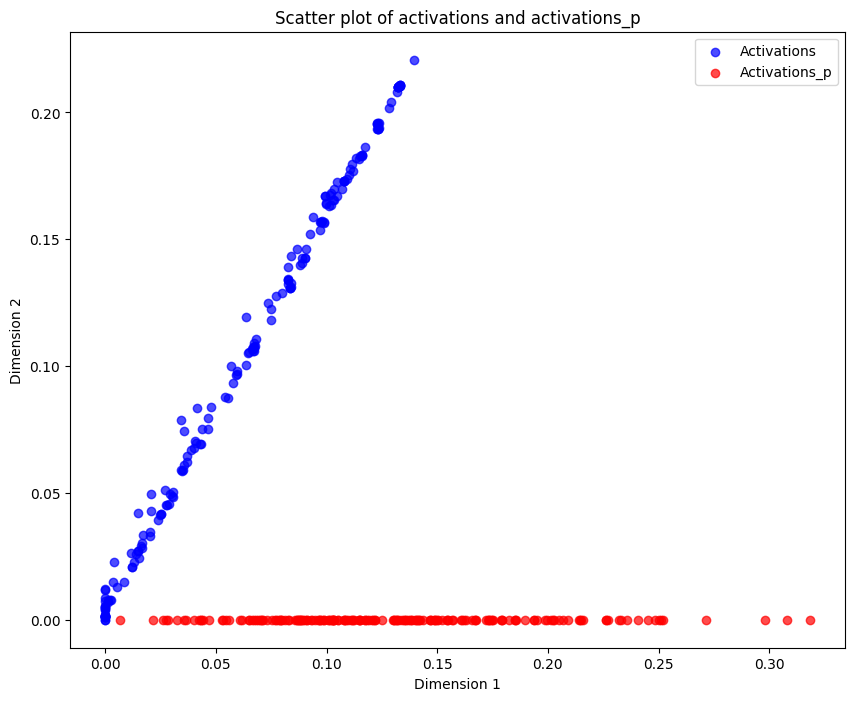

In [20]:
# prompt: Create a scatter plot of the activations and activations_p, also resolve this error "RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead."

import matplotlib.pyplot as plt

# Detach the activations and activations_p tensors from the computational graph
activations = activations.detach().numpy()
activations_p = activations_p.detach().numpy()

# Create a scatter plot of the activations and activations_p
plt.figure(figsize=(10, 8))
plt.scatter(activations[:, 0], activations[:, 1], c='blue', label='Activations', alpha=0.7)
plt.scatter(activations_p[:, 0], activations_p[:, 1], c='red', label='Activations_p', alpha=0.7)

# Add labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot of activations and activations_p')
plt.legend()

# Show the plot
plt.show()


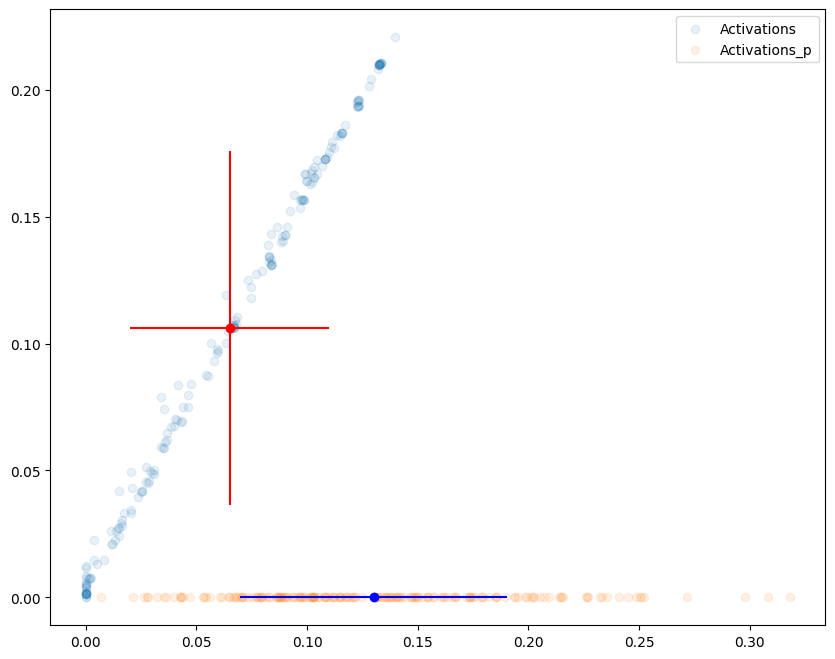

In [14]:
import matplotlib.pyplot as plt

# Create a scatter plot of the activations and activations_p
plt.figure(figsize=(10, 8))
# Detach activations from the computation graph before converting to NumPy
plt.scatter(activations.detach().numpy()[:, 0], activations.detach().numpy()[:, 1], alpha=0.1, label="Activations")
plt.scatter(activations_p.detach().numpy()[:, 0], activations_p.detach().numpy()[:, 1], alpha=0.1, label="Activations_p")

# Plot the mean and standard deviation of the activations and activations_p
# Detach mean_activations and mean_activations_p before converting to NumPy
plt.scatter(mean_activations.detach().numpy()[0], mean_activations.detach().numpy()[1], c="red")
plt.scatter(mean_activations_p.detach().numpy()[0], mean_activations_p.detach().numpy()[1], c="blue")

# Detach std_activations and std_activations_p before converting to NumPy
plt.errorbar(mean_activations.detach().numpy()[0], mean_activations.detach().numpy()[1], xerr=std_activations.detach().numpy()[0], yerr=std_activations.detach().numpy()[1], c="red", fmt="none")
plt.errorbar(mean_activations_p.detach().numpy()[0], mean_activations_p.detach().numpy()[1], xerr=std_activations_p.detach().numpy()[0], yerr=std_activations_p.detach().numpy()[1], c="blue", fmt="none")

plt.legend()
plt.show()

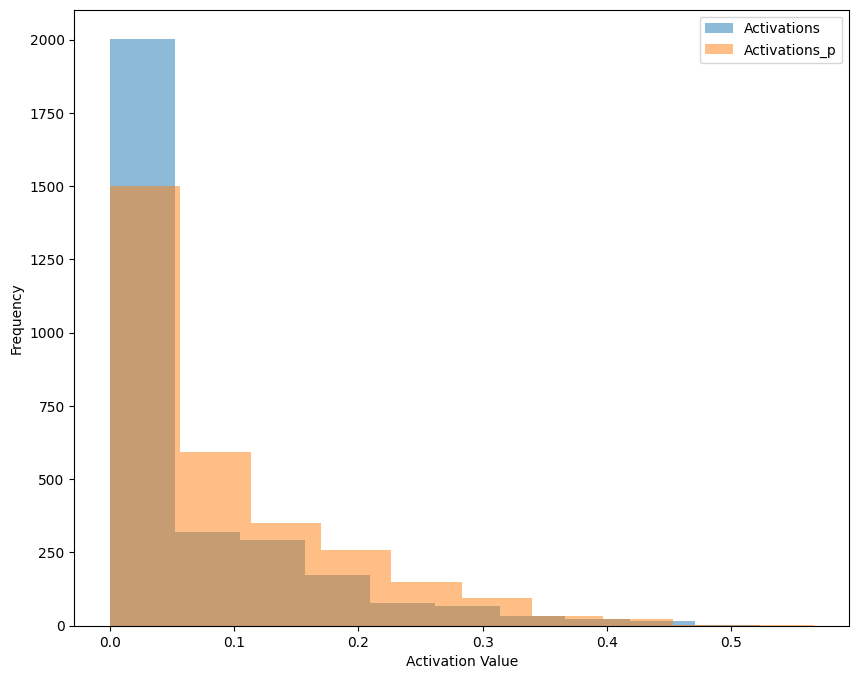

In [10]:
# prompt: Create a histogram of the activations and activations_p

import matplotlib.pyplot as plt

# Create a histogram of the activations and activations_p
plt.figure(figsize=(10, 8))
plt.hist(activations.detach().numpy().flatten(), alpha=0.5, label="Activations")
plt.hist(activations_p.detach().numpy().flatten(), alpha=0.5, label="Activations_p")

plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


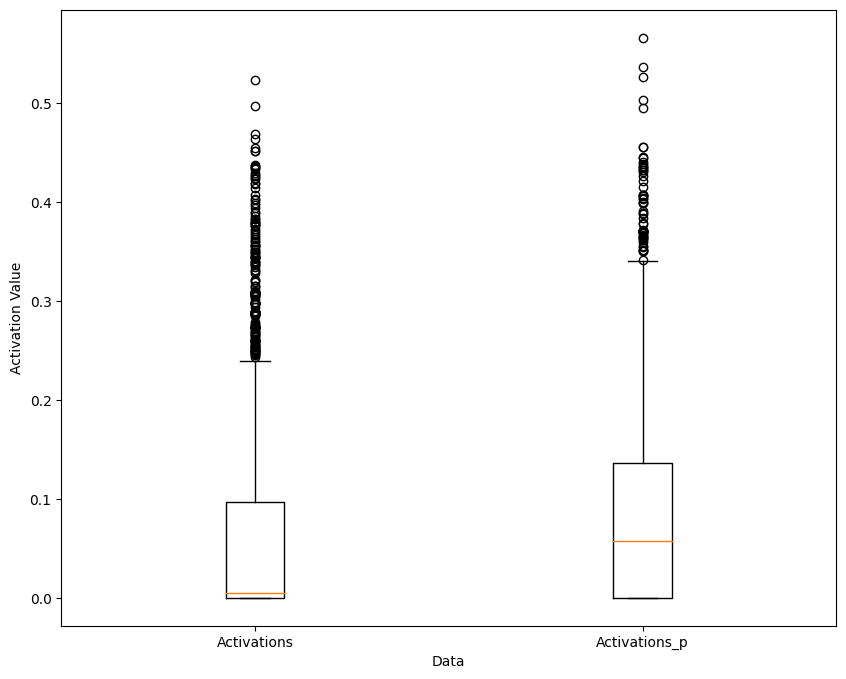

In [13]:
# prompt: Create a boxplot of the activations and activations_p

import matplotlib.pyplot as plt

# Create a boxplot of the activations and activations_p
plt.figure(figsize=(10, 8))
plt.boxplot([activations.detach().numpy().flatten(), activations_p.detach().numpy().flatten()], labels=["Activations", "Activations_p"])

plt.xlabel("Data")
plt.ylabel("Activation Value")
plt.show()


In [ ]:
# prompt: relative cluster size comparison

# Calculate the number of nodes in each cluster
cluster_sizes = [len(labels[labels == i]) for i in range(dataset.num_classes)]

# Calculate the relative cluster size
relative_cluster_sizes = [size / len(labels) for size in cluster_sizes]

# Print the relative cluster sizes
print("Relative cluster sizes:", relative_cluster_sizes)


Relative cluster sizes: [0.3351063829787234, 0.6648936170212766]


In [ ]:
# prompt: calculate silhouette_score, davies_bouldin_score and calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# Calculate the silhouette_score
silhouette_score = silhouette_score(activations_tsne, labels)

# Calculate the davies_bouldin_score
davies_bouldin_score = davies_bouldin_score(activations_tsne, labels)

# Calculate the calinski_harabasz_score
calinski_harabasz_score = calinski_harabasz_score(activations_tsne, labels)

# Print the scores
print("Silhouette Score:", silhouette_score)
print("Davies-Bouldin Score:", davies_bouldin_score)
print("Calinski-Harabasz Score:", calinski_harabasz_score)


Silhouette Score: 0.20780104
Davies-Bouldin Score: 1.5384973363069727
Calinski-Harabasz Score: 56.325135475372


In [ ]:
# prompt: classification report of model

from sklearn.metrics import classification_report

# Get predictions for the test set
model.eval()
predictions = []
true_labels = []
for data in test_loader:
    _, out = model(data)
    predictions.extend(out.argmax(dim=1).tolist())
    true_labels.extend(data.y.tolist())

# Generate the classification report
report = classification_report(true_labels, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.40      0.33      0.36        12
           1       0.71      0.77      0.74        26

    accuracy                           0.63        38
   macro avg       0.56      0.55      0.55        38
weighted avg       0.62      0.63      0.62        38



In [ ]:
# prompt: I have two model one is poisoned and other is clean , now i want to find sensitvity of model to poisoned data

# Define the sensitivity metric
def sensitivity(clean_acc, poisoned_acc):
  return (clean_acc - poisoned_acc) / clean_acc

# Calculate the clean and poisoned accuracies
clean_acc = 0.71
poisoned_acc = 0.63 # Replace with the accuracy of the poisoned model

# Calculate the sensitivity
sensitivity = sensitivity(clean_acc, poisoned_acc)

# Print the sensitivity
print(f"Sensitivity: {sensitivity}")


Sensitivity: 0.11267605633802812


In [ ]:
# prompt: convert this sensitvity to percentagge

sensitivity_percentage = sensitivity * 100
print(f"Sensitivity: {sensitivity_percentage:.2f}%")

Sensitivity: 11.27%


In [ ]:
def calculate_poisoned_performance(C_clean, S, P):
    """
    Calculate the performance of the model when poisoned data is introduced.

    Parameters:
    C_clean (float): Performance metric of the clean model (e.g., accuracy, precision).
    S (float): Sensitivity of the model to poisoned data.
    P (float): Proportion of poisoned data.

    Returns:
    float: Performance metric of the model with poisoned data.
    """
    C_poison = C_clean * (1 + S * P)
    return C_poison

# Example usage:
C_clean = 0.71  # Performance of the model with clean data
S = 0.11        # Sensitivity of the model to poisoned data
P = 0.1        # Proportion of poisoned data

C_poison = calculate_poisoned_performance(C_clean, S, P)
print(f"Performance of the model with poisoned data: {C_poison}")


Performance of the model with poisoned data: 0.7178099999999998
